* [Andrej Karpathy: Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&ab_channel=AndrejKarpathy)

In [1]:
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()
print(words[:8])
print(len(words))

chars = ["."] + sorted(list(set("".join(words))))
print(chars)
VOCAB_SIZE = len(chars)
print(f"{VOCAB_SIZE=}")

ctoi = {c:i for i,c in enumerate(chars)}
print(ctoi)
itoc = {i:c for c,i in ctoi.items()}
print(itoc)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033
['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
VOCAB_SIZE=27
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [2]:
import torch
import random

block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [ctoi["."]] * block_size
        for c in w + ".":
            X.append(context)
            idx = ctoi[c]
            Y.append(idx)
            # print(f"{''.join([itoc[i] for i in context])} -> {c}")
            context = context[1:] + [idx]


    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

# Splits: train (0.8), val/dev (0.1), test (0.1).
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


* [Kaiming init paper](https://arxiv.org/pdf/1502.01852)
* [NN init visualization](https://www.deeplearning.ai/ai-notes/initialization/index.html)
* [PyTorch kaiming init](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)
* [Batch Norm paper](https://arxiv.org/pdf/1502.03167)

In [3]:
g = torch.Generator().manual_seed(2147483647)

# Indexing into embedding table is the same as 1-hot encoding and matmul w/ embedding.
EMB_DIM = 10
C = torch.randn((VOCAB_SIZE, EMB_DIM), generator=g)

HIDDEN_DIM = 200
W1_kaiming_std = (5/3) / ((block_size * EMB_DIM) ** 0.5)  # gain for tanh / sqrt(fan_in).
print(f"{W1_kaiming_std=}")

W1 = torch.randn((block_size * EMB_DIM, HIDDEN_DIM), generator=g) * W1_kaiming_std

W2_kaiming_std = 1 / (HIDDEN_DIM ** 0.5)
print(f"{W2_kaiming_std=}")

bn_gain = torch.ones((1, HIDDEN_DIM))
bias = torch.zeros((1, HIDDEN_DIM))

running_mean = torch.zeros((1, HIDDEN_DIM))  # Not params, these are running stats.
running_std = torch.ones((1, HIDDEN_DIM))
bn_momentum = 0.999

W2 = torch.randn((HIDDEN_DIM, VOCAB_SIZE), generator=g) * W2_kaiming_std
b2 = torch.randn(VOCAB_SIZE, generator=g) * 0.01

parameters = [C, W1, bn_gain, bias, W2, b2]
for p in parameters:
    p.requires_grad = True

n_params = sum(p.numel() for p in parameters)
print(f"{n_params=}")

expected_init_loss = -torch.tensor(1.0 / VOCAB_SIZE).log()  # nll of uniform dist over vocab.
print(f"{expected_init_loss=}")

W1_kaiming_std=0.3042903097250923
W2_kaiming_std=0.07071067811865475
n_params=12097
expected_init_loss=tensor(3.2958)


0 loss=3.66926
10000 loss=2.03099
20000 loss=2.59905
30000 loss=2.03090
40000 loss=2.27403
50000 loss=1.88201
60000 loss=2.10912
70000 loss=2.30911
80000 loss=2.38106
90000 loss=2.05480
100000 loss=2.34766
110000 loss=2.25424
120000 loss=1.66128
130000 loss=1.87394
140000 loss=2.32660
150000 loss=1.95618
160000 loss=2.01769
170000 loss=2.38860
180000 loss=2.15034
190000 loss=2.07373
199999 loss=2.02003


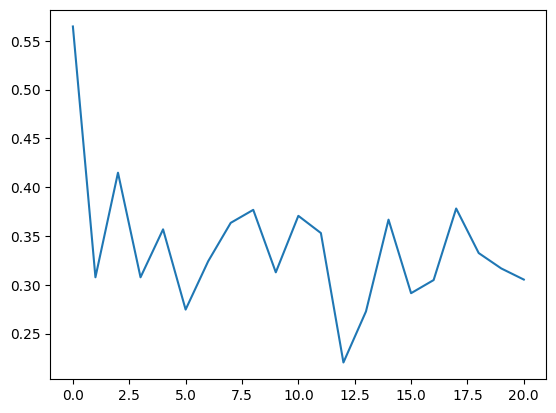

In [4]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

TRAIN_STEPS = 200_000
BATCH_SIZE = 32

log_losses = []
for i in range(TRAIN_STEPS):
    # Create minibatch.
    inds = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
    xb, yb = X_train[inds], Y_train[inds]

    # Forward.
    emb = C[xb]
    concat_emb = emb.view(emb.shape[0], -1)
    z = concat_emb @ W1

    bn_mean_i = z.mean(dim=0, keepdim=True)
    bn_std_i = z.std(dim=0, keepdim=True) + torch.finfo(torch.float32).eps
    z = bn_gain * ((z - bn_mean_i) / bn_std_i) + bias
    with torch.no_grad():
        running_mean = (bn_momentum * running_mean) + ((1-bn_momentum) * bn_mean_i)
        running_std = (bn_momentum * running_std) + ((1-bn_momentum) * bn_std_i)

    h = z.tanh()
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, yb)

    # Backward.
    for p in parameters:
        p.grad = None
    loss.backward()

    # Determine by increasing lr every step until training starts to diverges.
    # Decay learning rate on plateu (or lr scheduler).
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats.
    if ((i % 10_000) == 0) or (i == (TRAIN_STEPS - 1)):
        print(f"{i} loss={loss.item():.5f}")
        log_losses.append(loss.log10().item())

plt.plot(log_losses);

In [5]:
@torch.no_grad()
def eval_loss(X, Y):
    emb = C[X]
    concat_emb = emb.view(emb.shape[0], -1)
    z = concat_emb @ W1
    z = bn_gain * ((z - running_mean) / running_std) + bias
    h = z.tanh()

    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

print(f"Train loss: {eval_loss(X_train, Y_train)}")
print(f"Val loss: {eval_loss(X_val, Y_val)}")

Train loss: 2.068688154220581
Val loss: 2.108081817626953


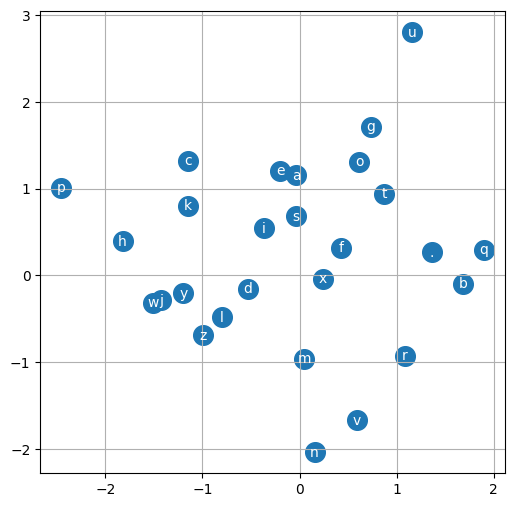

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(C[:, 0].detach().numpy(), C[:, 1].detach().numpy(), s=200)
for i in range(C.shape[0]):
    ax.text(C[i, 0].item(), C[i, 1].item(), itoc[i], ha="center", va="center", color="white")

ax.grid("minor");

In [7]:
@torch.no_grad()
def generate():
    new_word = []
    context = [ctoi["."]] * block_size

    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, emb_dim).
        concat_emb = emb.view(emb.shape[0], -1)
        z = concat_emb @ W1
        z = bn_gain * ((z - running_mean) / running_std) + bias
        h = z.tanh()  # (1, hidden_dim).
        logits = (h @ W2) + b2  # (1, hidden_dim)
        probs = logits.softmax(dim=-1)  # (1, hidden_dim)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        new_word.append(itoc[idx])
        context = context[1:] + [idx]

        if idx == 0:
            break

    return "".join(new_word)

for i in range(20):
    print(generate())

lay.
benjlesanae.
rurianna.
ellose.
shahmelrekule.
hazu.
abdo.
kateey.
maryaresumauven.
sarabir.
kollara.
sadano.
zarmee.
greyleightette.
greigh.
sequia.
sidrick.
lon.
tyron.
paastin.


# Torchify

In [8]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)  # kaiming init.
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, xb):
        self.out = xb @ self.weight  # (batch_size, fan_in) @ (fan_in, fan_out) = (batch_size, fan_out).
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):
        self.momentum = momentum
        self.training = True
        self.eps = eps

        # Params.
        self.scale = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # Buffers.
        self.running_mean = torch.zeros((1, dim))
        self.running_std = torch.ones((1, dim))

    def __call__(self, xb):
        if self.training:
            mean = xb.mean(dim=0, keepdim=True)
            std = xb.std(dim=0, keepdim=True)
            
            # Update running stats.
            with torch.no_grad():
                self.running_mean = ((1-self.momentum) * self.running_mean) + (self.momentum * mean)
                self.running_std = ((1-self.momentum) * self.running_std) + (self.momentum * std)
        else:
            mean = self.running_mean
            std = self.running_std

        normed = (xb - mean) / (std + self.eps)
        self.out = (self.scale * normed) + self.bias  # Track outputs for viz.
        return self.out
    
    def parameters(self):
        return [self.scale, self.bias]
    
class Tanh:
    def __call__(self, xb):
        self.out = xb.tanh()
        return self.out
    
    def parameters(self):
        return []
    

EMB_DIM = 10
HIDDEN_DIM = 100
C = torch.randn((VOCAB_SIZE, EMB_DIM), generator=g)

layers = [
    Linear(block_size * EMB_DIM, HIDDEN_DIM, bias=True), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=True), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=True), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=True), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, HIDDEN_DIM, bias=True), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, VOCAB_SIZE, bias=True), BatchNorm1d(VOCAB_SIZE)
]

with torch.no_grad():
    # Make output less confident.
    layers[-1].scale *= 0.1

    # Apply tanh gain.
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for l in layers for p in l.parameters()]
for p in parameters:
    p.requires_grad = True
n_params = sum(p.numel() for p in parameters)
print(f"{n_params=}")

expected_init_loss = -torch.tensor(1.0 / VOCAB_SIZE).log()  # nll of uniform dist over vocab.
print(f"{expected_init_loss=}")

n_params=47551
expected_init_loss=tensor(3.2958)


0 loss=3.28703
1 loss=3.28728
2 loss=3.27556
3 loss=3.28389
4 loss=3.28259
5 loss=3.28742
6 loss=3.29167
7 loss=3.24822
8 loss=3.26437
9 loss=3.24843
10 loss=3.23079
11 loss=3.26488
12 loss=3.25374
13 loss=3.18185
14 loss=3.20897
15 loss=3.21747
16 loss=3.23321
17 loss=3.19406
18 loss=3.18634
19 loss=3.19691
20 loss=3.16588
21 loss=3.22103
22 loss=3.17817
23 loss=3.12783
24 loss=3.18653
25 loss=3.23097
26 loss=3.11880
27 loss=3.19863
28 loss=3.13594
29 loss=3.12843
30 loss=3.12502
31 loss=3.17235
32 loss=3.17982
33 loss=3.15129
34 loss=3.19148
35 loss=3.08984
36 loss=3.06771
37 loss=3.17084
38 loss=3.10130
39 loss=3.19236
40 loss=3.06831
41 loss=3.08022
42 loss=3.03478
43 loss=3.08326
44 loss=3.07657
45 loss=3.02710
46 loss=3.14530
47 loss=3.05605
48 loss=3.04826
49 loss=3.10785
50 loss=2.96876
51 loss=3.07383
52 loss=3.04479
53 loss=3.05894
54 loss=3.12194
55 loss=2.99499
56 loss=3.01388
57 loss=3.09348
58 loss=3.02831
59 loss=3.07052
60 loss=3.02765
61 loss=3.02436
62 loss=3.12221
63

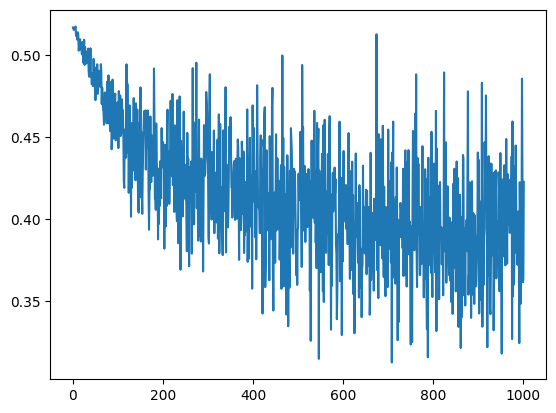

In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

TRAIN_STEPS = 200_000
BATCH_SIZE = 32

log_losses = []
update_data_ratios = []
for i in range(TRAIN_STEPS):
    # Create minibatch.
    inds = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
    xb, yb = X_train[inds], Y_train[inds]

    # Forward.
    emb = C[xb]
    z = emb.view(emb.shape[0], -1)
    for layer in layers:
        z = layer(z)
    loss = F.cross_entropy(z, yb)

    # Backward.
    for layer in layers:
        layer.out.retain_grad()  # DEBUG
    for p in parameters:
        p.grad = None
    loss.backward()

    # Optim.
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats.
    print(f"{i} loss={loss.item():.5f}")
    log_losses.append(loss.log10().item())
    with torch.no_grad():
        update_data_ratios.append([(lr*p.grad.std() / p.std()).log10().item() for p in parameters])

    if i > 1_000:
        break  # DEBUG

plt.plot(log_losses);

2 Tanh: mean=-0.001925 std=0.63156, saturated=2.96875%
5 Tanh: mean=0.005627 std=0.64399, saturated=2.40625%
8 Tanh: mean=-0.003348 std=0.64227, saturated=2.43750%
11 Tanh: mean=0.001577 std=0.64346, saturated=2.21875%
14 Tanh: mean=-0.004244 std=0.64417, saturated=2.25000%


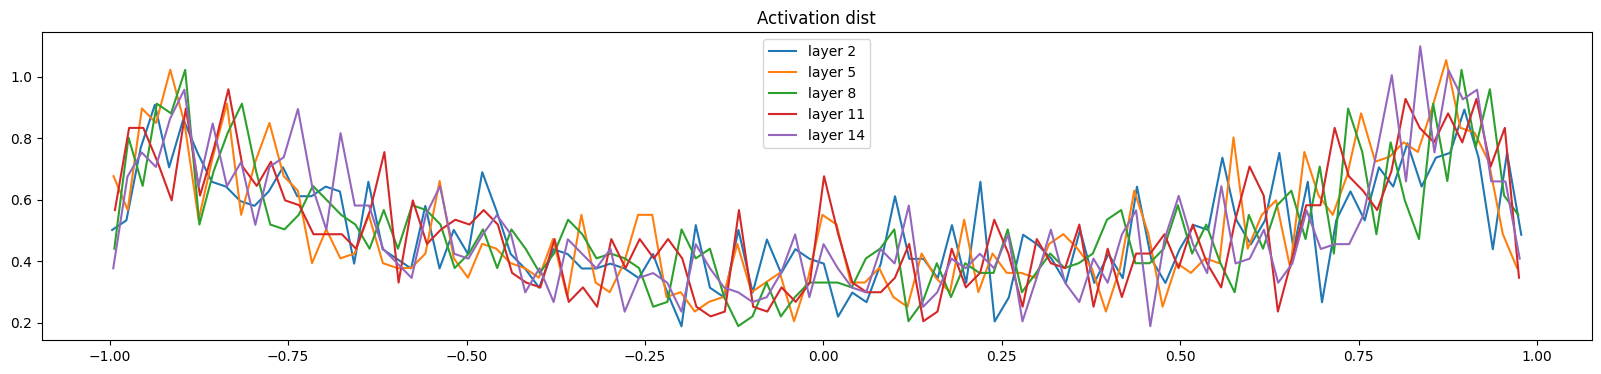

In [10]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if not isinstance(layer, Tanh):
        continue

    grads = layer.out
    print(f"{i} {layer.__class__.__name__}: mean={grads.mean():5f} std={grads.std():.5f}, saturated={(grads.abs()>0.97).float().mean()*100 :.5f}%")

    hy, hx = torch.histogram(grads, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i}")

plt.legend(legends)
plt.title("Activation dist");

2 Tanh: mean=0.000000 std=0.00356
5 Tanh: mean=0.000000 std=0.00312
8 Tanh: mean=0.000000 std=0.00290
11 Tanh: mean=0.000000 std=0.00258
14 Tanh: mean=0.000000 std=0.00244


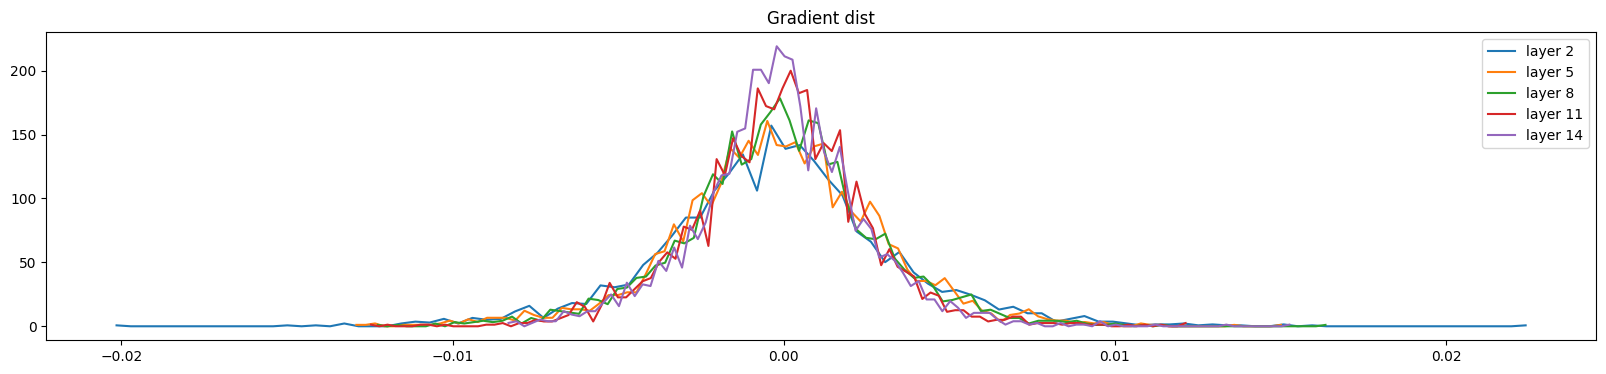

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if not isinstance(layer, Tanh):
        continue

    grads = layer.out.grad
    print(f"{i} {layer.__class__.__name__}: mean={grads.mean():5f} std={grads.std():.5f}")

    hy, hx = torch.histogram(grads, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i}")

plt.legend(legends)
plt.title("Gradient dist");

0 (27, 10): mean=-0.000000 std=0.00820 grad/data=0.00819033570587635
1 (30, 100): mean=-0.000195 std=0.00765 grad/data=0.024477088823914528
5 (100, 100): mean=-0.000097 std=0.00621 grad/data=0.03712897002696991
9 (100, 100): mean=0.000015 std=0.00556 grad/data=0.032976362854242325
13 (100, 100): mean=0.000008 std=0.00522 grad/data=0.031101584434509277
17 (100, 100): mean=0.000029 std=0.00483 grad/data=0.028763672336935997
21 (100, 27): mean=-0.000014 std=0.00928 grad/data=0.0556882843375206


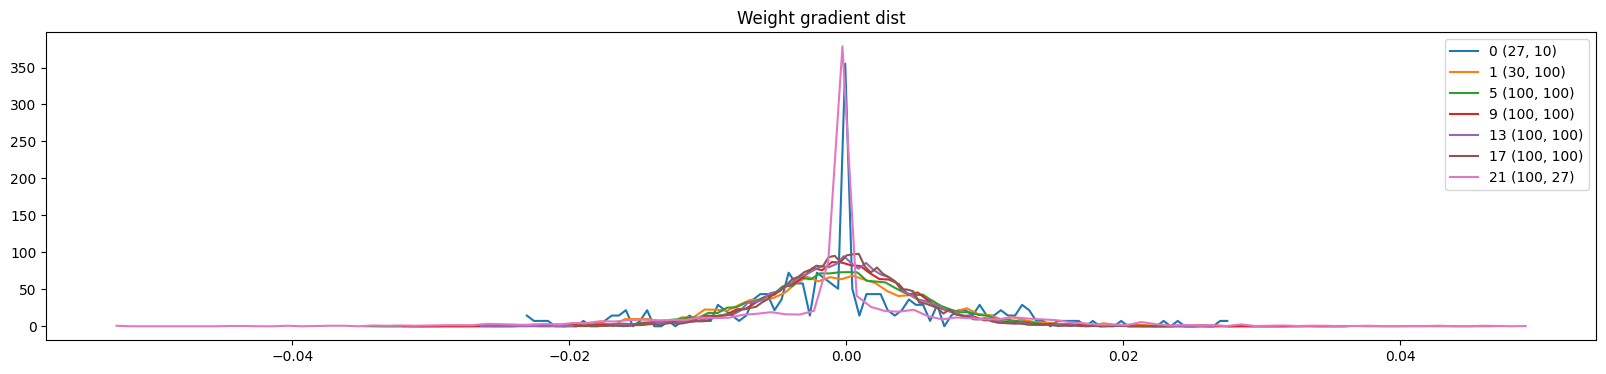

In [12]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim != 2:  # Only linear weights.
        continue

    grads = p.grad
    print(f"{i} {tuple(p.shape)}: mean={grads.mean():5f} std={grads.std():.5f} grad/data={grads.std() /  p.std()}")

    hy, hx = torch.histogram(grads, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"{i} {tuple(p.shape)}")

plt.legend(legends)
plt.title("Weight gradient dist");

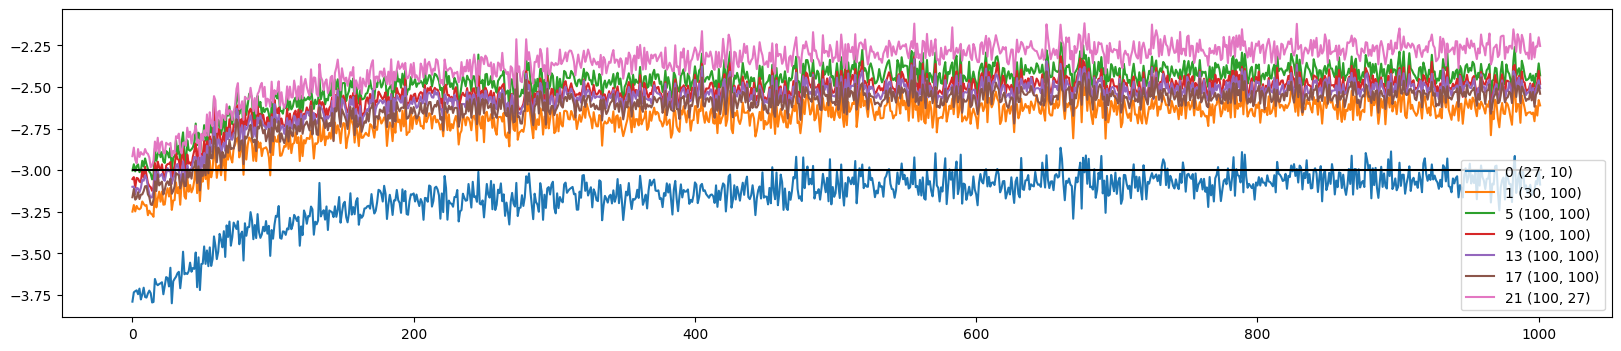

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim != 2:  # Only linear weights.
        continue

    plt.plot([update_data_ratios[j][i] for j in range(len(update_data_ratios))])
    legends.append(f"{i} {tuple(p.shape)}")

plt.hlines(-3, 0, len(update_data_ratios), color="black")  # ratios should be ~1e-3 (-3 in log10).

plt.legend(legends);